In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data_path = 'Bike-Sharing_hour_data.csv'
rides = pd.read_csv(data_path)

In [5]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
rides.shape

(17379, 17)

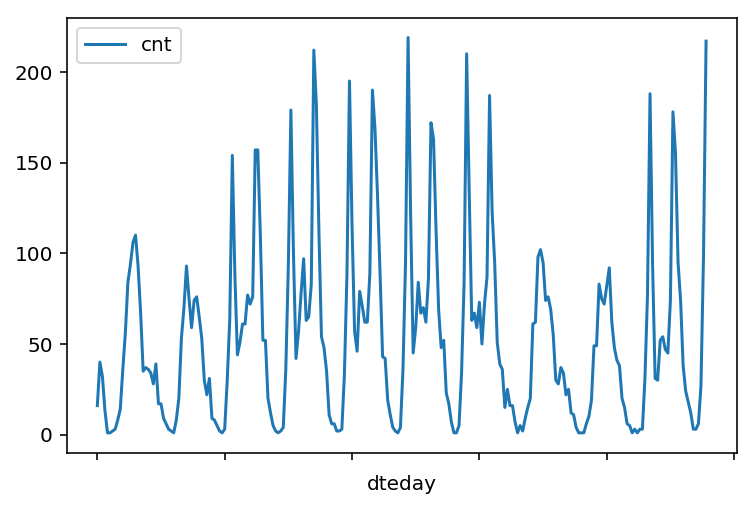

In [7]:
rides[:24*10].plot(x='dteday',y='cnt')
plt.show()

In [8]:
dummy_fields = ['season','weathersit','mnth','hr','weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each],prefix=each,drop_first=False)
    rides = pd.concat([rides,dummies],axis=1)
    
fields_to_drop = ['instant','dteday','season','weathersit','weekday','atemp','mnth','workingday','hr']
data = rides.drop(fields_to_drop,axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
quant_features = ['casual','registered','cnt','temp','hum','windspeed']
scaled_features = {}
for each in quant_features:
    mean,std = data[each].mean(),data[each].std()
    scaled_features[each]=[mean,std]
    data.loc[:,each] = (data[each]-mean)/std

In [10]:
scaled_features

{'casual': [35.67621842453536, 49.305030387053186],
 'registered': [153.78686920996606, 151.35728591258317],
 'cnt': [189.46308763450142, 181.38759909186527],
 'temp': [0.4969871684216586, 0.19255612124972407],
 'hum': [0.6272288394038822, 0.1929298340629125],
 'windspeed': [0.1900976063064631, 0.12234022857279413]}

In [11]:
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
test_data = data[-21*24:]
data = data[:-21*24]
target_fields =['cnt','casual','registered']
features,targets = data.drop(target_fields,axis=1),data[target_fields]
test_features,test_targets=test_data.drop(target_fields,axis=1),test_data[target_fields]

In [13]:
features.shape

(16875, 56)

In [14]:
test_data.shape

(504, 59)

In [15]:
train_features,train_targets = features[:-60*24],targets[:-60*24]
val_features,val_targets = features[-60*24:],targets[-60*24:]

In [16]:
val_features.shape

(1440, 56)

In [17]:
from keras.models import Sequential
from keras.layers import Dense

In [18]:
train_features.shape[1]

56

In [19]:
model = Sequential()
model.add(Dense(20, input_dim=train_features.shape[1], kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal'))

In [21]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                1140      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,161
Trainable params: 1,161
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(x=train_features, y=train_targets['cnt'], batch_size=10, epochs=20, verbose=1,
         validation_data=[val_features, val_targets['cnt']])

Train on 15435 samples, validate on 1440 samples
Epoch 1/20
15435/15435 [==============================] - 2s 104us/step - loss: 0.5154 - val_loss: 0.4871
Epoch 2/20
15435/15435 [==============================] - 1s 85us/step - loss: 0.2930 - val_loss: 0.4458
Epoch 3/20
15435/15435 [==============================] - 1s 87us/step - loss: 0.2702 - val_loss: 0.4316
Epoch 4/20
15435/15435 [==============================] - 1s 75us/step - loss: 0.2572 - val_loss: 0.4148
Epoch 5/20
15435/15435 [==============================] - 1s 77us/step - loss: 0.2496 - val_loss: 0.4058
Epoch 6/20
15435/15435 [==============================] - 1s 78us/step - loss: 0.2440 - val_loss: 0.4091
Epoch 7/20
15435/15435 [==============================] - 1s 75us/step - loss: 0.2387 - val_loss: 0.3925
Epoch 8/20
15435/15435 [==============================] - 1s 84us/step - loss: 0.2323 - val_loss: 0.3890
Epoch 9/20
15435/15435 [==============================] - 1s 87us/step - loss: 0.2199 - val_loss: 0.3706
Epoch

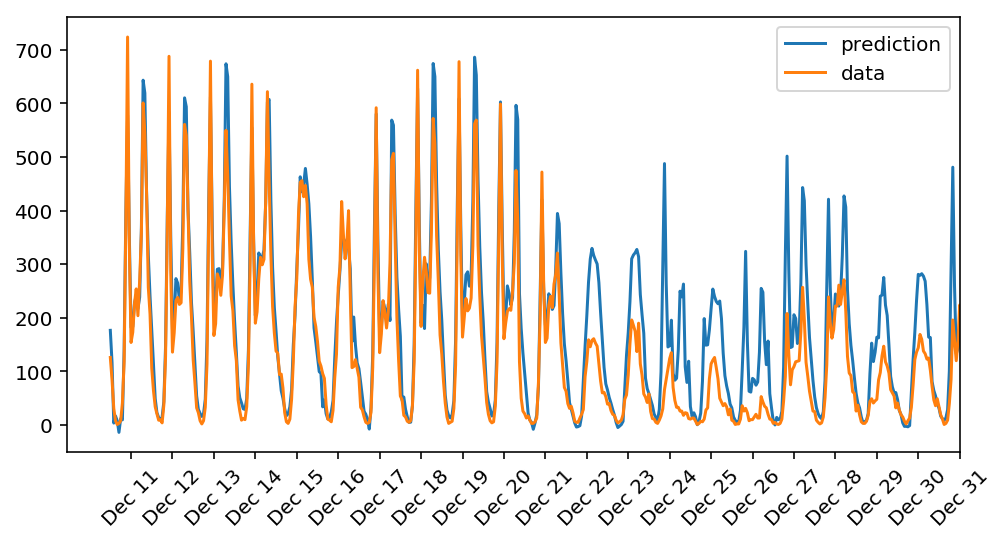

In [26]:
fig,ax = plt.subplots(figsize=(8,4))
mean,std = scaled_features['cnt']
predictions = model.predict(test_features).T*std+mean
ax.plot(predictions[0], label = 'prediction')
ax.plot((test_targets['cnt']*std+mean).values,label ='data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)